In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import os
import pylab as pl
import sys
import xarray as xr
import yaml

### Files paths

In [2]:
yaml_file = './config.yaml'
params = yaml.safe_load(open(yaml_file))

INPUT_GRID = params['input_grid_nc']
INPUT_PATH_SSH_FILTERED = params['input_path_data_filtered']
INPUT_PATH_SEG_MASKS = params['input_path_data_seg_masks']

# TODO optional, I may just do the whole processing here
OUTPUT_PATH_GRID_SUBSET = params['output_path_grid_subset']

# TODO: for every path in SSH, read the file and (delete the useless field)
# concatenate them, or read them with open_mfdataset()

### Read and print the mesh

In [3]:
data_mesh = xr.open_dataset(INPUT_GRID, engine='netcdf4')
data_mesh

<xarray.Dataset>
Dimensions:            (nz: 70, nz1: 69, elem: 17628297, nod2: 8852366, n3: 3,
                        n2: 2, N: 8, edg_n: 26481174, n4: 4)
Coordinates:
  * nz                 (nz) float64 0.0 -5.0 -10.0 ... -6e+03 -6.35e+03
  * nz1                (nz1) float64 -2.5 -7.5 -12.5 ... -5.825e+03 -6.175e+03
Dimensions without coordinates: elem, nod2, n3, n2, N, edg_n, n4
Data variables: (12/19)
    elem_area          (elem) float64 ...
    nlevels_nod2D      (nod2) int32 ...
    nlevels            (elem) int32 ...
    nod_in_elem2D_num  (nod2) int32 ...
    nod_part           (nod2) int32 ...
    elem_part          (elem) int32 ...
    ...                 ...
    nod_in_elem2D      (N, nod2) int32 ...
    edges              (n2, edg_n) int32 ...
    edge_tri           (n2, edg_n) int32 ...
    edge_cross_dxdy    (n4, edg_n) float64 ...
    gradient_sca_x     (elem, n3) float64 ...
    gradient_sca_y     (elem, n3) float64 ...

### Plot: entire world

Text(0, 0.5, 'Latitude')

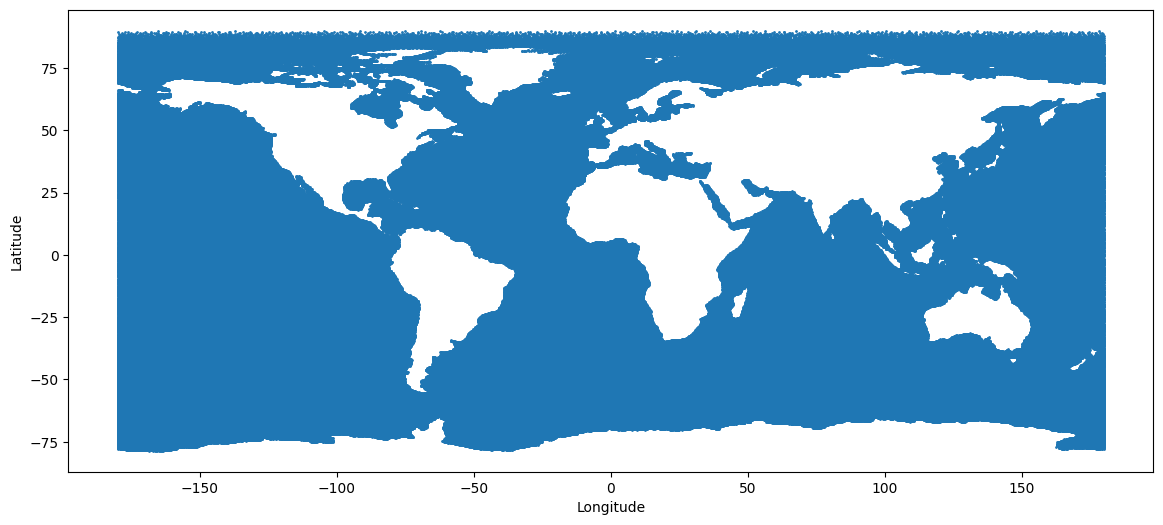

In [4]:
model_lon = data_mesh.lon.values
model_lat = data_mesh.lat.values

step = 10
plt.figure(figsize=(14, 6))
plt.scatter(model_lon[::step], model_lat[::step], s=1)
plt.xlabel('Longitude', size=10)
plt.ylabel('Latitude', size=10)

### Deletion of useless fields

In [5]:
vars_keys = data_mesh.data_vars
for key in vars_keys:
    if key != 'lat' and key != 'lon' and key != 'edges' and key != 'nodes':
        data_mesh = data_mesh.drop_vars(key)

data_mesh = data_mesh.drop_vars('nz')   # These 2 are coordinates, not variables
data_mesh = data_mesh.drop_vars('nz1')
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, n2: 2, edg_n: 26481174)
Dimensions without coordinates: nod2, n2, edg_n
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (n2, nod2) float64 ...
    edges    (n2, edg_n) int32 ...

### RoI & Plot: South Atlantic mask extraction (Eddy-rich region)

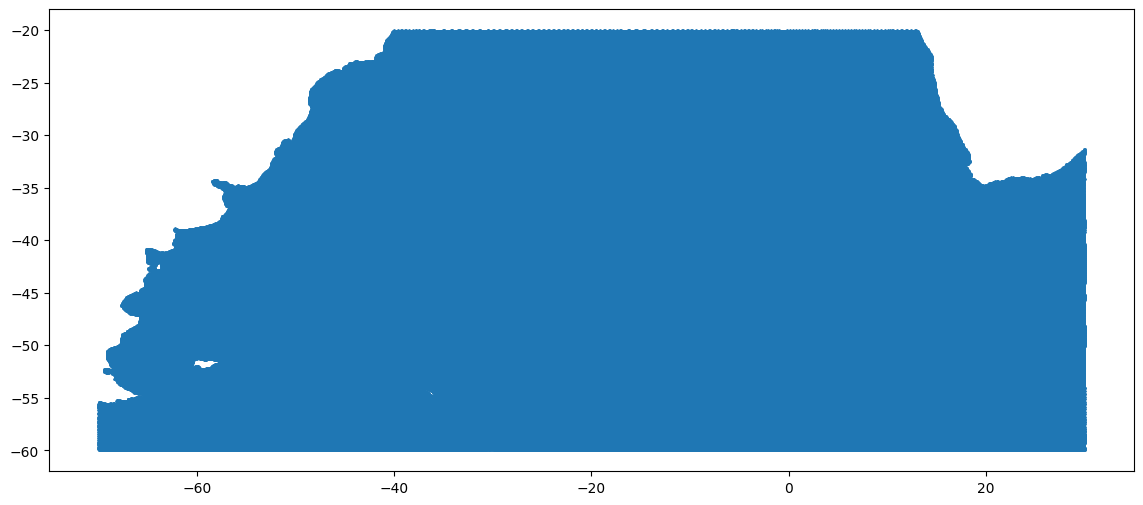

In [6]:
left = params['input_left']
right = params['input_right']
bottom = params['input_bottom']
top = params['input_top']
region_mask = (model_lon > left) & (model_lon < right) & (model_lat < top) & (model_lat > bottom)

step = 1
plt.figure(figsize=(14, 6))
plt.scatter(model_lon[region_mask][::step], model_lat[region_mask][::step], s=1)

### RoI: edges extraction

In [7]:
# Decrease by 1 since for compatibility with Fortran the indexes start from 1 instead of 0
edge_0 = data_mesh.edges[0].values
edge_1 = data_mesh.edges[1].values
edge_0 -= 1
edge_1 -= 1

edges_subset = []
for i in range(len(edge_0)):
    if region_mask[edge_0[i]] & region_mask[edge_1[i]]:
        edges_subset.append([edge_0[i], edge_1[i]])

edges_subset = np.array(edges_subset, dtype="int32")
data_mesh = data_mesh.drop_vars('edges')
data_mesh['edges'] = (('edges_subset', 'n2'), edges_subset)
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, n2: 2, edges_subset: 2268763)
Dimensions without coordinates: nod2, n2, edges_subset
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (n2, nod2) float64 ...
    edges    (edges_subset, n2) int32 1035320 1035378 ... 7106912 7106914

### RoI: nodes extraction

In [8]:
nodes_subset = []
for i in range(len(region_mask)):
    if region_mask[i]:
        nodes_subset.append(i)

nodes_subset = np.array(nodes_subset, dtype="int32")
data_mesh['nodes'] =(('nodes_subset'), nodes_subset)
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, nodes_subset: 757747, edges_subset: 2268763, n2: 2)
Dimensions without coordinates: nod2, nodes_subset, edges_subset, n2
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (nodes_subset) int32 1035320 1035324 1035345 ... 7853535 7853537
    edges    (edges_subset, n2) int32 1035320 1035378 ... 7106912 7106914

### Plot: final RoI

Text(0, 0.5, 'Latitude')

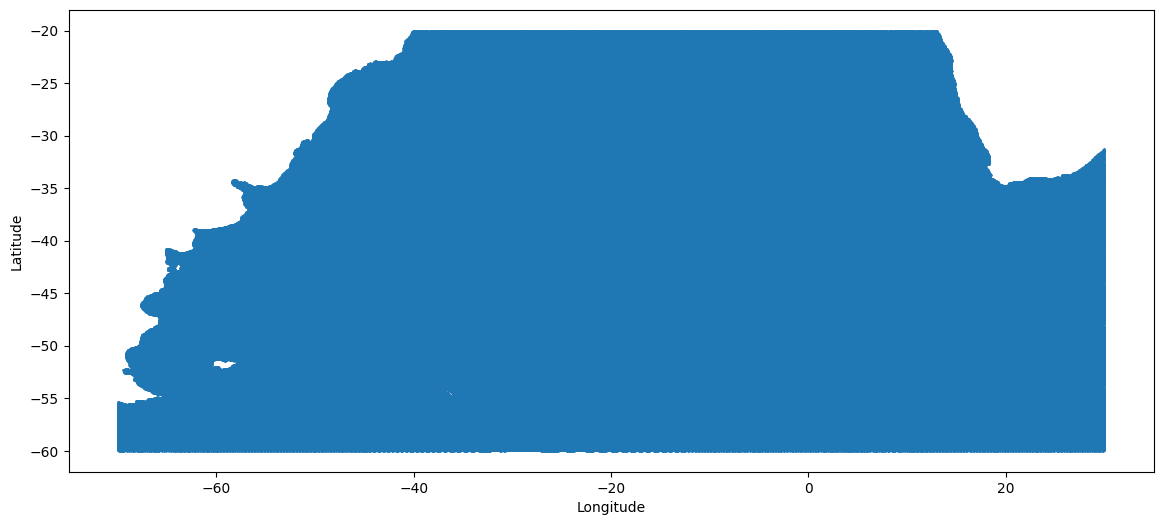

In [9]:
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values

step = 1
plt.figure(figsize=(14, 6))
plt.scatter(model_lon_roi[::step], model_lat_roi[::step], s=1)
plt.xlabel('Longitude', size=10)
plt.ylabel('Latitude', size=10)

### Plot: just the connections of the RoI
##### (If everything is green is because the selected area is dense with edges)

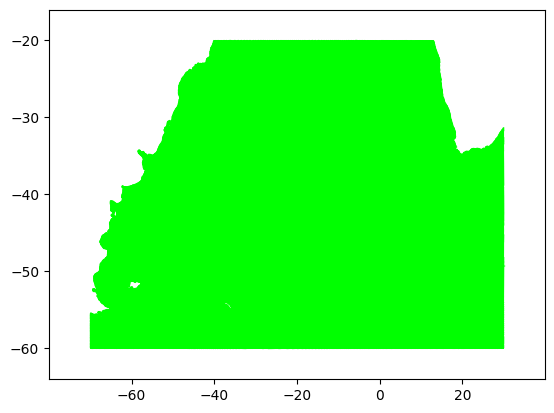

In [10]:
edge_0 = data_mesh.edges[:, 0].values
edge_1 = data_mesh.edges[:, 1].values
x_0 = []
y_0 = []
x_1 = []
y_1 = []
for i in range(edge_0.size):
    if region_mask[edge_0[i]] & region_mask[edge_1[i]]:
        # First the connection starting points
        x_0.append(float(model_lon[edge_0[i]]))
        y_0.append(float(model_lat[edge_0[i]]))
        # Then the connection end points
        x_1.append(float(model_lon[edge_1[i]]))
        y_1.append(float(model_lat[edge_1[i]]))

# Organizing the start and ending connection points for visualization
lines = []
for i in range(len(x_0)):
    lines.append([(x_0[i], y_0[i]), (x_1[i], y_1[i])])

# Color mask to green
c = [(0, 1, 0, 1)]*len(x_0)

lc = mc.LineCollection(lines, colors=c, linewidths=1)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.margins(0.1)
plt.show()

### Save the subset mesh(optional)

In [11]:
#data_mesh.to_netcdf(OUTPUT_PATH_GRID_SUBSET, engine='netcdf4')

### Inspect a filtered SSH file and its segmentation mask for the year defined in the .yaml file

In [12]:
year = str(params['year'])

data = []
for file in os.listdir(INPUT_PATH_SEG_MASKS):
    if year in file:
        data.append(file)

data.sort()

# Let's take February
data_02 = xr.open_dataset(INPUT_PATH_SEG_MASKS + '/' + data[1])

In [13]:
data_02

<xarray.Dataset>
Dimensions:    (LONGITUDE: 1200, LATITUDE: 480, TIME: 28)
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 -70.0 -69.92 -69.83 ... 29.75 29.83 29.92
  * LATITUDE   (LATITUDE) float32 -60.0 -59.92 -59.83 ... -20.25 -20.17 -20.08
  * TIME       (TIME) float32 5.706e+05 5.706e+05 ... 5.712e+05 5.712e+05
Data variables:
    ssh        (TIME, LONGITUDE, LATITUDE) float64 ...
    seg_mask   (TIME, LONGITUDE, LATITUDE) int64 ...

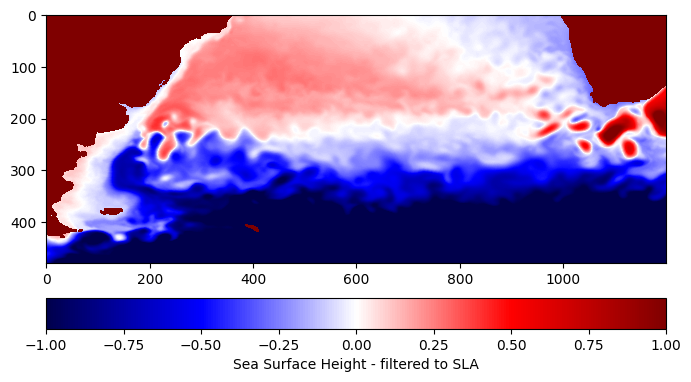

In [14]:
plot_data = data_02.ssh.values[0]

fig = plt.figure(figsize=(8, 4.5))
plt.imshow(np.flipud(plot_data.T), cmap=cm.seismic, vmin=-1, vmax=1)
cb = plt.colorbar(orientation='horizontal', pad=0.1)
cb.set_label('Sea Surface Height - filtered to SLA', size=10)

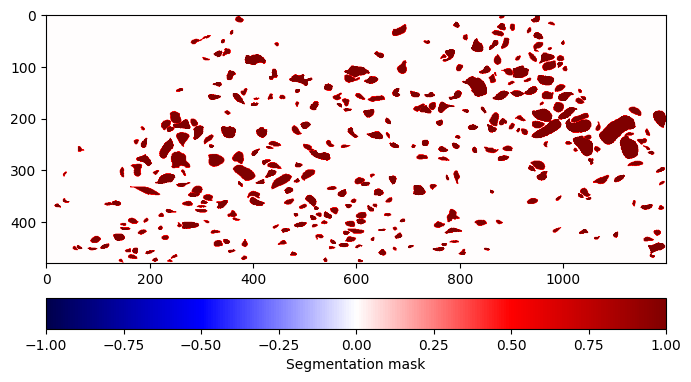

In [15]:
plot_data = data_02.seg_mask.values[0]

fig = plt.figure(figsize=(8, 4.5))
plt.imshow(np.flipud(plot_data.T), cmap=cm.seismic, vmin=-1, vmax=1)
cb = plt.colorbar(orientation='horizontal', pad=0.1)
cb.set_label('Segmentation mask', size=10)

## Interpolation of SSH and segmentation mask to the unstructured subset grid

### First, some helper functions from https://github.com/nextGEMS/nextGEMS_Cycle3/blob/main/FESOM/STARTHERE_FESOM.ipynb

In [16]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [17]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

In [18]:
from scipy.spatial import cKDTree

# Target coordinates(the unstructured FESOM mesh)
model_lon = data_mesh.lon[data_mesh.nodes].values
model_lat = data_mesh.lat[data_mesh.nodes].values

# Source coordinates(the SSH and segmentation masks information)
#data_lon, data_lat = np.meshgrid(data_02.dims['LONGITUDE'], data_02.dims['LATITUDE'])
data_lon = list(range(data_02.dims['LONGITUDE']))
data_lat = list(range(data_02.dims['LATITUDE']))
data_lon_2, data_lat_2 = np.meshgrid(data_lon, data_lat)

# SSH values
data_ssh_values = data_02.ssh.values[0]

# Segmentation mask
data_seg_mask_values = data_02.seg_mask.values[0]

print(np.shape(model_lon))
print(np.shape(model_lat))
print(np.shape(data_lon))
print(np.shape(data_lat))
print(np.shape(data_lon_2))
print(np.shape(data_lat_2))
print(np.shape(data_ssh_values))

(757747,)
(757747,)
(1200,)
(480,)
(480, 1200)
(480, 1200)
(1200, 480)


In [19]:
tmp_lon = data_lon_2.flatten()
tmp_lat = data_lat_2.flatten()
print(tmp_lon)
print(tmp_lat)
tmp_ssh = data_ssh_values.flatten()
print(np.shape(tmp_ssh))

[   0    1    2 ... 1197 1198 1199]
[  0   0   0 ... 479 479 479]
(576000,)


In [20]:
distances, inds = create_indexes_and_distances(model_lon, model_lat, data_lon_2, data_lat_2, k=1, workers=-1)

In [21]:
# TODO I'm not using this data_interpolated at the moment
radius_of_influence = 5000
data_interpolated = data_mesh.nodes[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = np.ma.masked_invalid(data_interpolated)
data_interpolated

masked_array(data=[-2147483648, -2147483648, -2147483648, ...,
                   -2147483648, -2147483648, -2147483648],
             mask=[False, False, False, ..., False, False, False],
       fill_value=999999,
            dtype=int32)

In [22]:
distances.shape, inds.shape

((576000,), (576000,))

In [23]:
min(inds), max(inds)

(3, 757746)

### Create an intermediate dictionary structure to work with these indexes

In [24]:
inds_dict = {}

for i in range(data_mesh.dims['nodes_subset']):
    inds_dict[i] = []

for i in range(len(inds)):
    inds_dict[inds[i]].append(i)

# Just printing to check that everything's ok
for i in range(10):
    print(i, inds_dict[i])

0 []
1 []
2 []
3 [249639, 249999, 250359, 250719, 265252, 265612, 265972, 266332, 268856, 269216, 269576, 269936, 271259, 271619, 271979, 272339, 272461, 272821, 273181, 273541, 277269, 277629, 277989, 278349, 278471, 278831, 279191, 279551, 279674, 280034, 280394, 280754, 280877, 281237, 281597, 281957, 282080, 282081, 282440, 282441, 282800, 282801, 283160, 283161, 283284, 283285, 283644, 283645, 284004, 284005, 284364, 284365, 284489, 284490, 284849, 284850, 285209, 285210, 285569, 285570, 285696, 285697, 285698, 286056, 286057, 286058, 286416, 286417, 286418, 286776, 286777, 286778, 362676, 362677, 362678, 363036, 363037, 363038, 363396, 363397, 363398, 363869, 363870, 364229, 364230, 364589, 364590, 365064, 365065, 365424, 365425, 365784, 365785, 366260, 366261, 366620, 366621, 366980, 366981, 367457, 367817, 368177, 368654, 369014, 369374, 369851, 370211, 370571, 371049, 371409, 371769, 375841, 376201, 376561, 377039, 377399, 377759, 379436, 379796, 380156, 383032, 383392, 383752

In [25]:
ssh = []
seg_mask = []

# Just testing this out
flat_ssh = data_ssh_values.flatten()
flat_seg_mask = data_seg_mask_values.flatten()

for i in range(data_mesh.dims['nodes_subset']):
    
    if len(inds_dict[i]) == 0:    # No ssh values were associated to the mesh node i
        ssh.append(np.nan)
    else:
        ssh_average = 0
    
        for k in inds_dict[i]:
            ssh_average += flat_ssh[k]
            continue
    
        ssh_average /= len(inds_dict[i])
        ssh.append(ssh_average)

# Just printing to check that everything's ok
for i in range(10):
    print(i, ssh[i])

0 nan
1 nan
2 nan
3 -0.43404597183319904
4 nan
5 nan
6 nan
7 nan
8 nan
9 nan


In [26]:
ssh = np.array(ssh, dtype="float64")
data_mesh['ssh'] =(('nodes_subset'), ssh)
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, nodes_subset: 757747, edges_subset: 2268763, n2: 2)
Dimensions without coordinates: nod2, nodes_subset, edges_subset, n2
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (nodes_subset) int32 1035320 1035324 1035345 ... 7853535 7853537
    edges    (edges_subset, n2) int32 1035320 1035378 ... 7106912 7106914
    ssh      (nodes_subset) float64 nan nan nan -0.434 ... nan nan nan -0.4463

### The amount of SSH information was clearly reduced in the process

In [27]:
not_nan_ssh = np.count_nonzero(~np.isnan(data_mesh.ssh.values))
not_nan_ssh_actual_proportion = not_nan_ssh*100/data_mesh.dims['nodes_subset']
not_nan_ssh_ideal_proportion = len(flat_ssh)*100/data_mesh.dims['nodes_subset']

print(f"Nodes with initial SSH data:\t\t\t{data_mesh.dims['nodes_subset']}")
print(f"Nodes with SSH data after pre-processing:\t  {not_nan_ssh}")
print(f"Ideal % of SSH info after pre-processing:\t{not_nan_ssh_ideal_proportion:.3f}%")
print(f"Actual % of SSH info after pre-processing:\t {not_nan_ssh_actual_proportion:.3f}%")

Nodes with initial SSH data:			757747
Nodes with SSH data after pre-processing:	  4161
Ideal % of SSH info after pre-processing:	76.015%
Actual % of SSH info after pre-processing:	 0.549%


### Group of plots to understand where we started and where we got

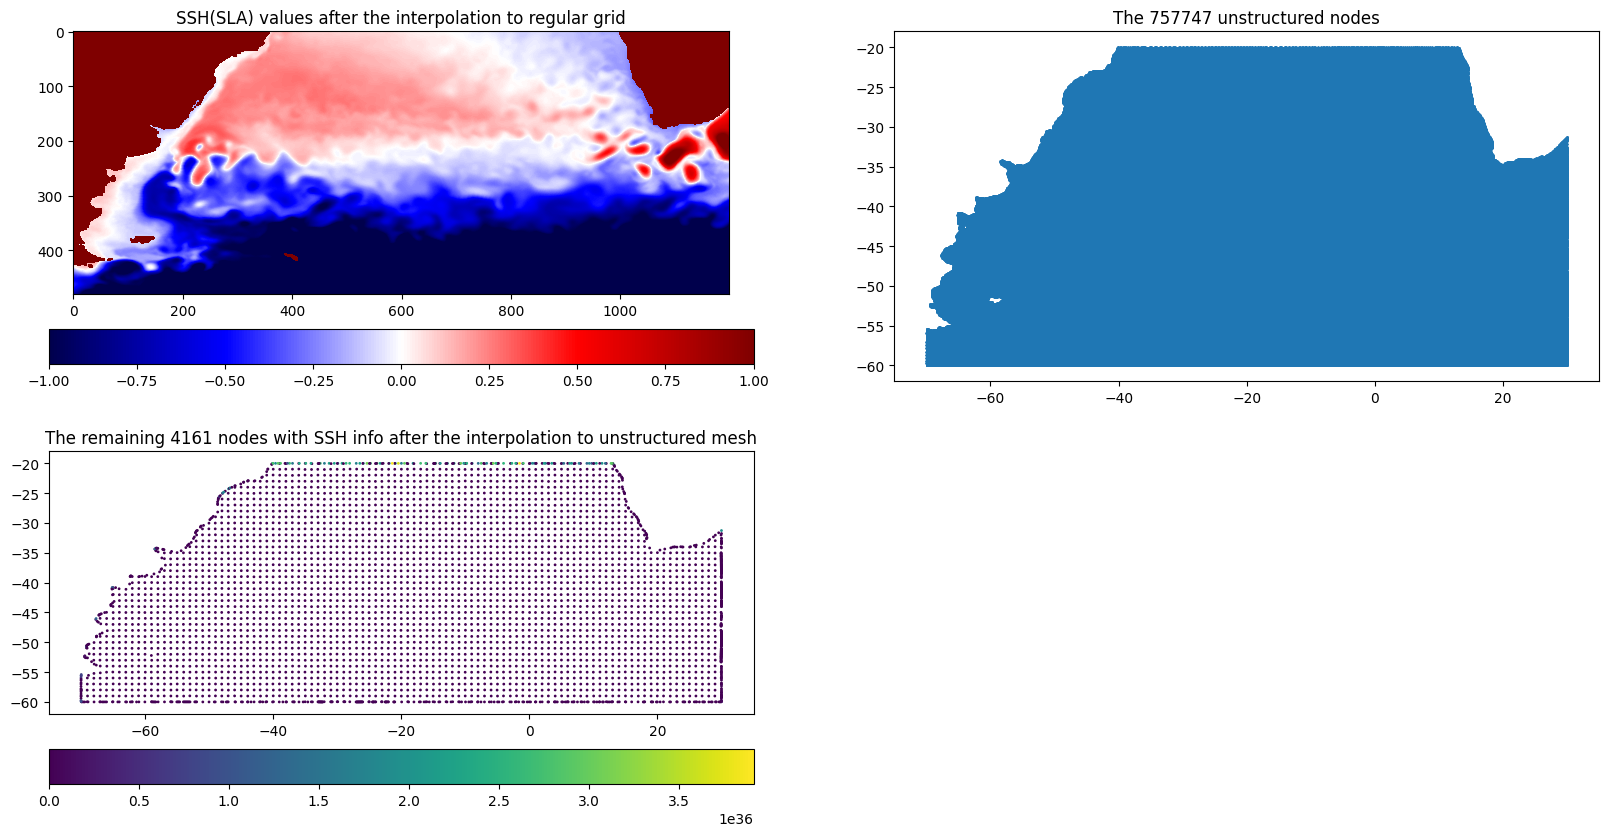

In [28]:
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values
uns_ssh = data_mesh.ssh.values
str_ssh = data_02.ssh.values[0]

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

im = axes[0][0].imshow(np.flipud(str_ssh.T), cmap=cm.seismic, vmin=-1, vmax=1)
axes[0][0].set_title("SSH(SLA) values after the interpolation to regular grid")
cb = plt.colorbar(im, orientation='horizontal', pad=0.1, ax=axes[0][0])

axes[0][1].scatter(model_lon_roi, model_lat_roi, s=1)
axes[0][1].set_title(f"The {data_mesh.dims['nodes_subset']} unstructured nodes")

im = axes[1][0].scatter(model_lon_roi, model_lat_roi, c=uns_ssh, s=1)
axes[1][0].set_title(f"The remaining {not_nan_ssh} nodes with SSH info after the interpolation to unstructured mesh")
plt.colorbar(im, orientation='horizontal', pad=0.1, ax=axes[1][0])

axes[1][1].axis('off')

plt.show()

### Distribution problem - multiple ssh values are associated to the same node, and some nodes don't have ssh information

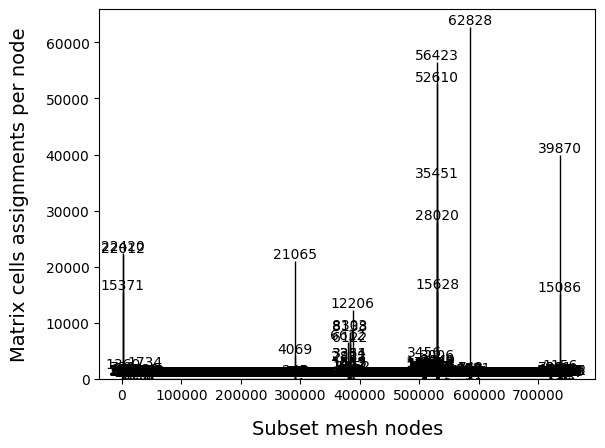

In [29]:
bins = np.unique(inds)
counts, edges, bars = plt.hist(inds, bins=bins, edgecolor='black')
plt.xlabel("Subset mesh nodes", labelpad=12, fontsize=14)
plt.ylabel("Matrix cells assignments per node", labelpad=12, fontsize=14)
#plt.xticks(bins, rotation=50)
plt.bar_label(bars)
plt.show()